In [4]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
import time
import pandas as pd
from numpy.linalg import norm
from itertools import count
from IPython import display
import seaborn as sns
from IPython.display import HTML
#from scipy.io import loadmat
from operator_functions.pointer_func import pointer_vector
from operator_functions.AB_operator import A_operator,B_operator,uBC_Laplace,b_vector_creator
from operator_functions.Conjugate_gradient import CG_solver,CG_solver_transient_Matrix,CG_solver_transient
from operator_functions.bound_append import bound_appender
from operator_functions.helper_util import Func_GaussElimination,plotter_animation_contour
import time
from joblib import Parallel, delayed

In [107]:
##diffusivity
alpha  = 0.005 ;
## Delta t
dt = 0.02 ;
## grid
Nx=9
Ny=10
xtotal  = np.linspace(0,1,Nx+2)
x=xtotal[1:Nx+1]
ytotal  = np.linspace(0,1,Ny+2)
y=ytotal[1:Ny+1]
dx = x[1] - x[0] 
dy=y[1] - y[0] 
xv, yv = np.meshgrid(x, y, indexing='ij')
X,Y=np.meshgrid(xtotal, ytotal, indexing='ij')
kappa=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
b=-1*kappa/(alpha)
Q=np.zeros((Nx*Ny,1))
BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
b_residual_list=[]
cg_iter_list=[10,50,100,200,250]
#for cg_iter in cg_iter_list:
#    Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
#    b_residual_list.append(b_residual)
cg_iter=100
Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
N=Nx*Ny
matrix_A=[]
matrix_B=[]

BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)

for i in range(N):
   Q=np.zeros((N,1))
   Q[i,0]=1
   matrix_A.append(list(A_operator(Q,Nx,Ny,dx,dy,dt,alpha)[:,0]))
    
   Q=np.zeros((N,1))
   Q[i,0]=1
   matrix_B.append(list(B_operator(Q,Nx,Ny,dx,dy,dt,alpha)[:,0]))
matrix_A=np.array(matrix_A)
inv_A=np.linalg.inv(matrix_A)
matrix_B=np.array(matrix_B)
inv_B=np.linalg.inv(matrix_B)
dt_range=[0.01,0.1,1,10]

In [126]:
Nx=9
Ny=10
iQ=pointer_vector(Nx, Ny)
#u_new_s=np.arange(0,len(Steady_ss)).reshape(Nx,Ny)
#u_vec_s=np.reshape(Steady_ss, (Nx,Ny), order='C')
#xv, yv = np.meshgrid(x, y, indexing='ij')
u_new_s=np.arange(0,Nx*Ny).reshape(Nx,Ny)
u_new_s[:,0]=0
u_new_s[:,1]=0
#u_vec_s=np.reshape(u_new_s[0:iu[-1,-1]+1], (nx-1,ny), order='C')

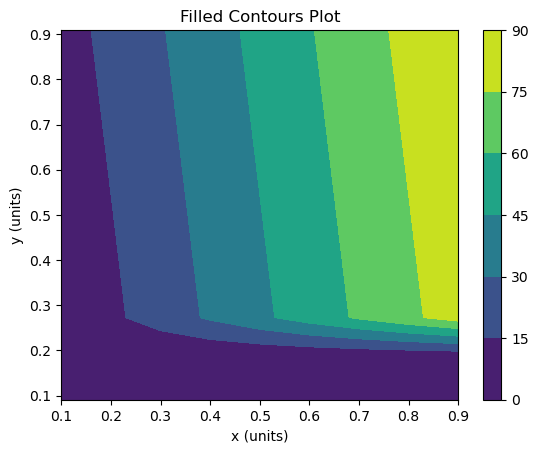

In [127]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, u_new_s)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [128]:
vis_mat=pd.DataFrame(u_new_s.T)
vis_mat=vis_mat[::-1]
vis_mat.columns=[f"x={i}" for i in vis_mat.columns]
vis_mat.index=[f"y={i}" for i in vis_mat.index]

In [129]:
vis_mat

,x=0,x=1,x=2,x=3,x=4,x=5,x=6,x=7,x=8
y=9,9,19,29,39,49,59,69,79,89
y=8,8,18,28,38,48,58,68,78,88
y=7,7,17,27,37,47,57,67,77,87
y=6,6,16,26,36,46,56,66,76,86
y=5,5,15,25,35,45,55,65,75,85
y=4,4,14,24,34,44,54,64,74,84
y=3,3,13,23,33,43,53,63,73,83
y=2,2,12,22,32,42,52,62,72,82
y=1,0,0,0,0,0,0,0,0,0
y=0,0,0,0,0,0,0,0,0,0


In [106]:
u_new_s.shape

(10, 10)

In [ ]:
def is_hermitian_positive_semidefinite(X):
    if X.shape[0] != X.shape[1]: # must be a square matrix
        return False

    if not np.all( X - X.T == 0 ): # must be a symmetric or hermitian matrix
        return False

    try: # Cholesky decomposition fails for matrices that are NOT positive definite.

        # But since the matrix may be positive SEMI-definite due to rank deficiency
        # we must regularize.
        regularized_X = X + np.eye(X.shape[0]) * 1e-14

        np.linalg.cholesky(regularized_X)
    except np.linalg.LinAlgError:
        return False

    return True

In [ ]:
is_hermitian_positive_semidefinite(matrix_B)

In [ ]:
plt.plot([i for i in range(len(b_residual))],b_residual,label=f"cg_iter={cg_iter}")
plt.legend()
plt.show()

In [ ]:
def timer_iteration(dt):
    kappa=dt*kappa_base
    Q=np.zeros((Nx*Ny,1))
    norm_list=[]
    b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    for it in range(100):
        b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
        Q,Solution_Matrix=CG_solver_transient(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
        norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
        if it%10==0:
            print(it*dt,norm_l2)
        norm_list.append(norm_l2)
        if norm_l2<1e-4:
            break
    return Q,norm_list

In [ ]:
norm_list_total=[]
iter_list_total=[]
t = time.time()
results = Parallel(n_jobs=2)(delayed(timer_iteration)(dt) for dt in [0.1,1,5,10])
print(time.time()-t)

In [ ]:
plt.plot([i for i in range(len(results[0]))],results[0],label=f"dt={dt_range[0]}")
plt.plot([i for i in range(len(results[1]))],results[1],label=f"dt={dt_range[1]}")
plt.plot([i for i in range(len(results[2]))],results[2],label=f"dt={dt_range[2]}")
plt.plot([i for i in range(len(results[3]))],results[3],label=f"dt={dt_range[3]}")
plt.legend()
plt.show()

In [3]:
norm_list_total=[]
iter_list_total=[]
Solution_Matrix_list=[]
b_residual_list=[]
kappa_base=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
dt_range=[1]
for dt in dt_range:
    ## grid
    kappa=dt*kappa_base
    Q=np.zeros((Nx*Ny,1))
    BCB=(-0.3)*np.ones(Nx)
    BCL=0.5-0.5*np.cos(2*np.pi*y)
    BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
    BCR=np.zeros(Ny)
    norm_list=[]
    iter_list=[]
    #b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    for it in range(1000):
        #b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
        Q,Solution_Matrix,b_residual=CG_solver_transient(Q,kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
        norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
        if it%10==0:
            print(it*dt,norm_l2)
        norm_list.append(norm_l2)
        iter_list.append(it)
        if norm_l2<1e-4:
            b_residual_list.append(b_residual)
            break
        Solution_Matrix_list.append(Solution_Matrix)
    norm_list_total.append(norm_list)
    iter_list_total.append(iter_list)

0 0.9290678061669092
10 0.6335861370956881
20 0.4437174274716311
30 0.3010499245879097
40 0.19257603148666466
50 0.11163725727388547
60 0.05800721559987832
70 0.04721691352272086
80 0.06966694905242383
90 0.09466050723104692
100 0.11562314940084588
110 0.13231490527061118
120 0.14539306351376924
130 0.15557135720630952
140 0.16346654418221732
150 0.16957932980289747
160 0.17430690527470286
170 0.17796039433692024
180 0.18078257845666337
190 0.18296176523909902
200 0.18464414935457157
210 0.18594266029027293
220 0.18694466472945862
230 0.18771783034876294
240 0.1883140233072831
250 0.18877350630603826
260 0.1891282366096929
270 0.18940038624802677
280 0.18961071931415496
290 0.1897717664693979
300 0.18989268123810235
310 0.18998186713037057
320 0.19004184369700677
330 0.1900823535472766
340 0.19010015744100553
350 0.19010761750169483
360 0.19011483829913212
370 0.19012182724314697
380 0.19012859177698102
390 0.19013513910583402
400 0.19014147620359764
410 0.19014760982027715
420 0.19015

KeyboardInterrupt: 

In [ ]:
uBC_Laplace

In [ ]:
plt.plot([i for i in range(len(b_residual))],b_residual,label=f"dt={dt_range[0]}")
# plt.plot([i for i in range(len(norm_list_total[1]))],norm_list_total[1],label=f"dt={dt_range[1]}")
# plt.plot([i for i in range(len(norm_list_total[2]))],norm_list_total[2],label=f"dt={dt_range[2]}")
# plt.plot([i for i in range(len(norm_list_total[3]))],norm_list_total[3],label=f"dt={dt_range[3]}")
# plt.legend()
# plt.show()

In [ ]:
dat_acq_int=1
HTML(plotter_animation_contour(xv,yv,Solution_Matrix_list,interv=100,dat_acq=dat_acq_int,p=0,q=1).to_html5_video())

In [ ]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, Solution_Matrix)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [ ]:
norm_list_total=[]
iter_list_total=[]
kappa_base=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
## grid
dt=0.01
kappa=(2*dt)*kappa_base
Q=np.zeros((Nx*Ny,1))
BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
norm_list=[]
iter_list=[]
b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
for it in range(20000):
    b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
    #Q=np.linalg.solve(matrix_B, b)
    Q,Solution_Matrix=CG_solver_transient_Matrix(matrix_B,Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
    if it%100==0:
        print(it*dt,norm_l2)
    norm_list.append(norm_l2)
    iter_list.append(it)
    if norm_l2<1e-4:
        break
    if it>3:
        if (norm_list[-1]-norm_list[-2])>0.00001:
            break
norm_list_total.append(norm_list)
iter_list_total.append(iter_list)

In [ ]:
b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)

In [ ]:
norm_list_total.µ, append(norm_list)

In [ ]:
plt.plot([i for i in range(len(norm_list_total[0]))],norm_list_total[0],label=f"dt={dt_range[0]}")
#plt.plot([i for i in range(len(norm_list_total[1]))],norm_list_total[1],label=f"dt={dt_range[1]}")
#plt.plot([i for i in range(len(norm_list_total[2]))],norm_list_total[2],label=f"dt={dt_range[2]}")
#plt.plot([i for i in range(len(norm_list_total[3]))],norm_list_total[3],label=f"dt={dt_range[3]}")
plt.legend()
plt.show()

In [ ]:
Mat_sol=np.zeros((Nx,Ny))
iQ=pointer_vector(Nx, Ny)
for i in range(0,Nx):
    for j in range(0,Ny):
        Mat_sol[i,j] = Q[iQ[i, j]]

In [ ]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, Mat_sol)
fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [ ]:
np.max(Q)

In [ ]:
from scipy import sparse
matrix_B = sparse.csr_matrix(matrix_B)

In [ ]:
matrix_B.shape